In [1]:
import pathlib
import json

# data
import xarray
import numpy as np
import pandas as pd

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import osgeo.osr

# 3d
from tvtk.api  import tvtk
from mayavi import mlab


In [2]:
#  A python  implementation of the Web Mercator version  of mapbox
earth_radius = 6371008.8
earth_circumfrence = 2 * np.pi * earth_radius

def lat_from_mercator_y(y):
    y2 = 180 - y * 360
    return 360 / np.pi * np.arctan(np.exp(y2 * np.pi / 180)) - 90


def mercator_scale(lat):
    return 1 / np.cos(lat * np.pi / 180)

def meter_in_mercator_coordinate_units(y):
    return 1 / earth_circumfrence * mercator_scale(lat_from_mercator_y(y))


def mercator_y_from_lat(lat):
    return (180 - (180 / np.pi * np.log(np.tan(np.pi / 4 + lat * np.pi / 360)))) / 360


def mercator_x_from_lng(lng):
    return (180 + lng) / 360

def circumference_at_latitude(latitude):
    return earth_circumfrence * np.cos(latitude * np.pi / 180)

def mercator_z_from_altitude(altitude, lat):
    return altitude / circumference_at_latitude(lat)


def scale_at_lat(lat):
    meter_at_lat = meter_in_mercator_coordinate_units(mercator_y_from_lat(lat))
    meter_at_0 = meter_in_mercator_coordinate_units(mercator_y_from_lat(0))
    return meter_at_lat / meter_at_0




In [3]:
ds_paths = list(pathlib.Path('~/data/odv/climatology').expanduser().glob('Water*.nc'))

wgs84 = osgeo.osr.SpatialReference()
webmercator = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
webmercator.ImportFromEPSG(3857)
wgs2wm =  osgeo.osr.CoordinateTransformation(wgs84, webmercator)

In [4]:
ds = xarray.open_dataset(ds_paths[0])
# ds.Temperature
ds.Salinity


<xarray.DataArray 'Salinity' (time: 12, depth: 41, lat: 109, lon: 113)>
[6059964 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -4.0 -3.875 -3.75 -3.625 ... 9.625 9.75 9.875 10.0
  * lat      (lat) float64 48.5 48.62 48.75 48.88 ... 61.62 61.75 61.88 62.0
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 ... 550.0 600.0 650.0 700.0
  * time     (time) datetime64[ns] 1984-01-16 1984-02-16 ... 1984-12-16
Attributes:
    units:          1e-3
    standard_name:  sea_water_salinity
    long_name:      sea water salinity
    cell_methods:   time: mean within years time: mean over years

In [5]:
# get list of standard names
def attribute_names(ds, attribute='standard_name'):
    attr_by_var = {}
    for var in ds.variables:
        attrs = getattr(ds, var).attrs    
        try:
            attr_by_var[attrs[attribute]] = var
        except KeyError:
            pass
    return attr_by_var
attribute_names(ds, 'long_name')


{'longitude': 'obslon',
 'latitude': 'obslat',
 'depth below sea level': 'obsdepth',
 'time': 'obstime',
 'sea water salinity': 'Salinity',
 'sea water salinity masked using relative error threshold 0.3': 'Salinity_L1',
 'sea water salinity masked using relative error threshold 0.5': 'Salinity_L2',
 'Relative error of sea water salinity': 'Salinity_relerr',
 'observation identifier': 'obsid'}

In [6]:
#  Testing the conversion  to mapbox coordinates
helsinki = {
    "lng": 25.004,
    "lat": 60.239
}
berlin = {
    "lng": 13.403,
    "lat": 52.562
}
kyiv = {
    "lng": 30.498,
    "lat": 50.541
}

zero = {
    'lng': 0,
    "lat": 0
}


helsinki['x'] = 0.5694555555555555
helsinki['y'] = 0.28906703939214295

berlin['x'] = 0.5372305555555555
berlin['y'] = 0.3277633358931997

kyiv['x'] = 0.5847166666666667
kyiv['y'] = 0.33679357865410225

zero['x'] = 0.5
zero['y'] = 0.5

def latlng2mapbox(lat, lon, z=None):

    # compute the extent of the web mercator projection
    rad_max = 2 * np.arctan(np.exp(np.pi)) - (np.pi / 2)
    deg_max = np.rad2deg(rad_max)
    _, y_max, _ = wgs2wm.TransformPoint(deg_max,  0)

    if z is None:
        z = np.zeros_like(lat)
    latlonz = np.c_[lat, lon, z]
    xyz_3857 = np.array(wgs2wm.TransformPoints(latlonz))
    # rescale to 0, 0 - 1, 1
    xyz_mapbox = (xyz_3857 / (y_max * 2)) + 0.5
    # with y flipped
    xyz_mapbox[:, 1] = 1 - xyz_mapbox[:, 1]
    xyz_mapbox[:, 2] = xyz_3857[:, 2] 
    return xyz_mapbox

#  validate our projection method
for obj in [helsinki, berlin, kyiv, zero]:
    obj['xyz_3857'] = np.array(wgs2wm.TransformPoint(obj['lat'], obj['lng']))
    obj['xyz_mapbox'] = latlng2mapbox(obj['lat'], obj['lng'])
    # xyz_mapbox should be the same as x, y, z
    print(obj)



{'lng': 25.004, 'lat': 60.239, 'x': 0.5694555555555555, 'y': 0.28906703939214295, 'xyz_3857': array([2783432.54779501, 8453141.91589834,       0.        ]), 'xyz_mapbox': array([[0.56945556, 0.28906704, 0.        ]])}
{'lng': 13.403, 'lat': 52.562, 'x': 0.5372305555555555, 'y': 0.3277633358931997, 'xyz_3857': array([1492015.13510225, 6902387.1879484 ,       0.        ]), 'xyz_mapbox': array([[0.53723056, 0.32776334, 0.        ]])}
{'lng': 30.498, 'lat': 50.541, 'x': 0.5847166666666667, 'y': 0.33679357865410225, 'xyz_3857': array([3395021.83021326, 6540500.0586304 ,       0.        ]), 'xyz_mapbox': array([[0.58471667, 0.33679358, 0.        ]])}
{'lng': 0, 'lat': 0, 'x': 0.5, 'y': 0.5, 'xyz_3857': array([0., 0., 0.]), 'xyz_mapbox': array([[0.5, 0.5, 0. ]])}


In [75]:
def compute_contours(ds_path, variable='Salinity', percentiles=None):
    """compute a set  of contours for a dataset"""
    ds = xarray.open_dataset(ds_path)
    
    
    # guess the names 
    # not generic, but input data is not well defined
    # multiple lat/lon in one file
    # standard names not always filled in
    
    # or get variables from grid variable 
    var = getattr(ds, variable)

    try:
        lat = getattr(var, 'lat')
    except AttributeError:
        lat = getattr(var, 'latitude')
    try:
        lon = getattr(var, 'lon')
    except AttributeError:
        lon = getattr(var, 'longitude')
    
    try: 
        height = getattr(var, 'depth')
    except AttributeError:
        height = getattr(var, 'altitude')
    
    # if positive is down, switch to up
    if getattr(height, 'positive', 'up') == 'down':
        height = height.values * -1
    else:
        height = height.values
    
    meta = {}
    meta['path'] = str(ds_path)
    
    # Lookup index of time dimension and average over it
    

    # Lookup array with values
    arr = np.squeeze(var.mean(dim='time').values)

    # lookup extent of values
    var_min = np.nanmin(arr)
    var_max = np.nanmax(arr)

    # define  percentiles
    q = [1, 25,  50,  75, 99]
    q = [5, 95]
    if percentiles  is None:
        percentiles = np.nanpercentile(arr, q)

    
    meta['variable'] = variable
    meta['var_min'] = var_min
    meta['var_max'] = var_max
    meta['percentiles'] = percentiles.tolist()

    # change dimenions  to x,y,z
    # This assumes data are in z, lat, lon
    arr = np.moveaxis(arr, [0, 1, 2], [2, 1, 0])

    # deal with missing data
    arr_masked = np.ma.masked_invalid(arr)
    
    # create gridded coordinates
    Lat, Lon, Z = np.meshgrid(lat.values, lon.values, height)
    

    # Tranform to mapbox coordinates
    xyz = latlng2mapbox(Lat.ravel(), Lon.ravel(), Z.ravel())
    
    print(xyz.min(axis=0))
    print(xyz.max(axis=0))
    
    
    X = xyz[:, 0].reshape(Lon.shape)
    Y = xyz[:, 1].reshape(Lat.shape)
    
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)
    z_min, z_max = np.min(Z), np.max(Z)
    
    lat_min, lat_max = Lat.min(), Lat.max()
    lon_min, lon_max = Lon.min(), Lon.max()
    
    meta['x_min'] = x_min
    meta['x_max'] = x_max
    meta['y_min'] = y_min
    meta['y_max'] = y_max
    meta['z_min'] = z_min
    meta['z_max'] = z_max
    meta['lat_min'] = lat_min
    meta['lat_max'] = lat_max
    meta['lon_min'] = lon_min
    meta['lon_max'] = lon_max
    
    # TODO: replace by Rectilinear Grid
    grid =  tvtk.StructuredGrid(dimensions=X.shape[::-1])
    # TODO use arr_masked.mask to "blank out points"
    grid.points = xyz

    point_mask = arr_masked.mask
    # get the indices where the array is masked
    point_idxs, = np.where(point_mask.ravel())
    # blank out the cells
    for point_idx in point_idxs:
        grid.blank_point(point_idx)
    
    cell_mask = arr_masked.mask 
    cell_mask = np.logical_or(cell_mask[:-1, :, :], cell_mask[1:, :, :])
    cell_mask = np.logical_or(cell_mask[:, :-1, :], cell_mask[:, 1:, :])
    cell_mask = np.logical_or(cell_mask[:, :, :-1], cell_mask[:, :, 1:])

    # get the indices where the array is masked
    cell_idxs, = np.where(cell_mask.ravel())
    # blank out the cells
    for cell_idx in cell_idxs:
        grid.blank_cell(cell_idx)
    
    
    
    grid.point_data.scalars = arr_masked.ravel()
    grid.point_data.scalars.name = 'scalars'
    grid.modified()
    meta['grid'] = grid
        
    vtk_path = ds_path.with_suffix('.vtk')
    print(vtk_path)
    writer = tvtk.DataSetWriter(file_name=str(vtk_path))
    writer.add_input_data_object(grid)
    writer.update()
    writer.write()
    
    contours = []
    for percentile in percentiles:
        contour =  tvtk.ContourFilter()
        contour.set_value(0, percentile)
        contour.set_input_data(grid)
        contour.use_scalar_tree =  True
        contour.compute_normals = True
        contour.update()
        # get rid of nan points
        clean = tvtk.CleanPolyData()
        clean.set_input_data(contour.output)
        clean.update()
        contours.append(clean.output)
    return meta, contours

In [77]:
# two degrees
results = []
for ds_path in ds_paths:
    meta, contours = compute_contours(ds_path, variable='Salinity', percentiles=None)
    results.append({
        "meta": meta,
        "contours": contours
    })

/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 4.88888889e-01  2.78936017e-01 -7.00000000e+02]
[0.52777778 0.3455286  0.        ]
/Users/baart_f/data/odv/climatology/Water_body_Salinity_NorthSea.4Danl_monthly.vtk


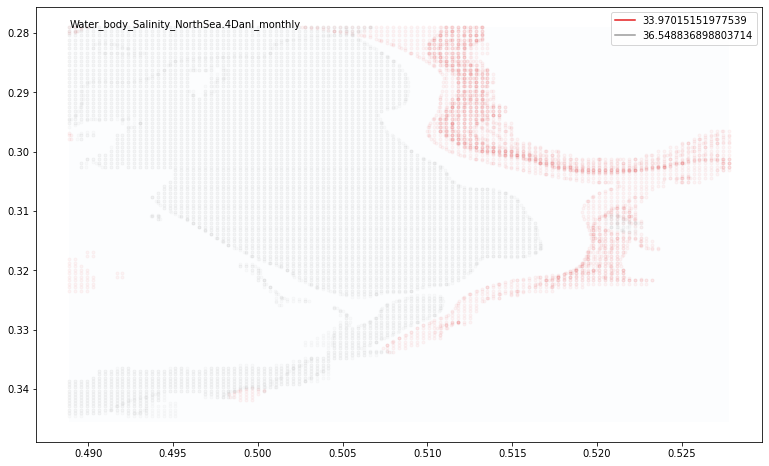

In [79]:
fig, ax = plt.subplots(figsize=(13, 8))
N = matplotlib.colors.Normalize(np.min(meta['percentiles']), np.max(meta['percentiles']))
for result in results:
    meta, contours = result['meta'], result['contours']
    
    colors = matplotlib.cm.Set1(N(meta['percentiles']))

    for color, contour, percentile in list(zip(colors, contours, meta['percentiles'])):
        df =  pd.DataFrame(contour.points, columns=['x', 'y', 'z'])
        ax.plot(df.x, df.y, '.', alpha=0.04, color=color)
    rect = np.array([
        [meta['x_min'], meta['y_min']],
        [meta['x_max'], meta['y_min']],
        [meta['x_max'], meta['y_max']],
        [meta['x_min'], meta['y_max']]
    ])
    ax.annotate(pathlib.Path(meta['path']).stem, [meta['x_min'], meta['y_min']])
    ax.fill(rect[:, 0], rect[:, 1], alpha=0.01)
    
ylim = ax.get_ylim()[::-1]
xlim = ax.get_xlim()
colors = matplotlib.cm.Set1(N(meta['percentiles']))
# render offscreen
for percentile, color in zip(meta['percentiles'], colors):
    ax.plot(0, 0, color=color, label=percentile)
# reset limits
ax.set_ylim(ylim)
ax.set_xlim(xlim)
    
ax.legend()


In [82]:
N = matplotlib.colors.Normalize(0, 20)

for result in results:
    meta = result['meta']
    contours = result['contours']
    ds_path = pathlib.Path(meta['path'])
    base_dir = ds_path.with_suffix('') 
    base_dir.mkdir(exist_ok=True)

    paths = []

    for i, (contour, percentile) in enumerate(zip(contours, meta['percentiles'])):

        # TODO: rescale all to  meters  (* 200000 for x/y)
        # and then scale back
        smooth = tvtk.SmoothPolyDataFilter()
        smooth.relaxation_factor  = 0.000001
        smooth.add_input_data_object(contour)
        smooth.update()
        
        decimate = tvtk.DecimatePro()
        decimate.add_input_data_object(smooth.output)
        decimate.update()

        transform_filter = tvtk.TransformFilter()
        transform = tvtk.Transform()
        x_min = meta['x_min']
        x_max = meta['x_max']
        y_min = meta['y_min']
        y_max = meta['y_max']
        z_min = meta['z_min']
        z_max = meta['z_max']
        lat_min = meta['lat_min'] 
        lat_max = meta['lat_max'] 
        lon_min = meta['lon_min'] 
        lon_max = meta['lon_max'] 

        transform.translate(-x_min, -y_min, -z_min)
        # transform.scale(1/(x_max - x_min), 1/(y_max - y_min), 1/(z_max - z_min))
        transform_filter.transform = transform
        transform_filter.add_input_data_object(smooth.output)
        transform_filter.update()
        base_path = base_dir / "polydata-{}-{:04d}".format(meta['variable'], i)

        ply_path = base_path.with_suffix('.ply')
        vtk_path = base_path.with_suffix('.vtk')
        paths.append(str(ply_path.relative_to(base_dir)))

        writer = tvtk.DataSetWriter(file_name=str(vtk_path))
        writer.add_input_data_object(contour)
        writer.update()
        
        if (writer.input.points):
            print('min', np.min(writer.input.points, axis=0))
            print('max', np.max(writer.input.points, axis=0))
        writer.write()

    meta['paths'] = paths

    with (base_dir / 'meta').with_suffix('.json').open('w') as f:
        pd.Series(meta).to_json(f)




min [  0.48888889   0.27893602 -57.70305677]
max [0.52777778 0.34182833 0.        ]
min [  0.48888889   0.27893602 -22.29450071]
max [ 0.52256944  0.34447798 -0.31465836]


In [81]:
!open  $base_dir